In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# import the libraries
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', category=FutureWarning)

plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 300
plt.style.use('seaborn')

import pandas as pd 
from pandas_datareader import data as wb
from datetime import datetime
import backtrader as bt

In [10]:
# define the class representing the trading strategy
class SmaSignal(bt.Signal):
    params = (('period', 40), )
    
    def __init__(self):
        self.lines.signal = self.data - bt.ind.SMA(period=self.p.period)

In [4]:
# download data from Yahoo
# df_rbs = round(wb.DataReader('RBS.L',
                             #data_source='yahoo',
                             #start='2015-1-1'),2)

In [11]:
# set up the backtest
data = bt.feeds.YahooFinanceData(dataname='RBS.L', 
                                 fromdate=datetime(2019, 1, 1),
                                 todate=datetime(2020, 6, 9))


In [6]:
#df_rbs.head()

In [12]:
# set up the backtest
cerebro = bt.Cerebro(stdstats = False)

cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.add_signal(bt.SIGNAL_LONG, SmaSignal)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

In [13]:
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 1000.00
Final Portfolio Value: 994.08


<IPython.core.display.Javascript object>


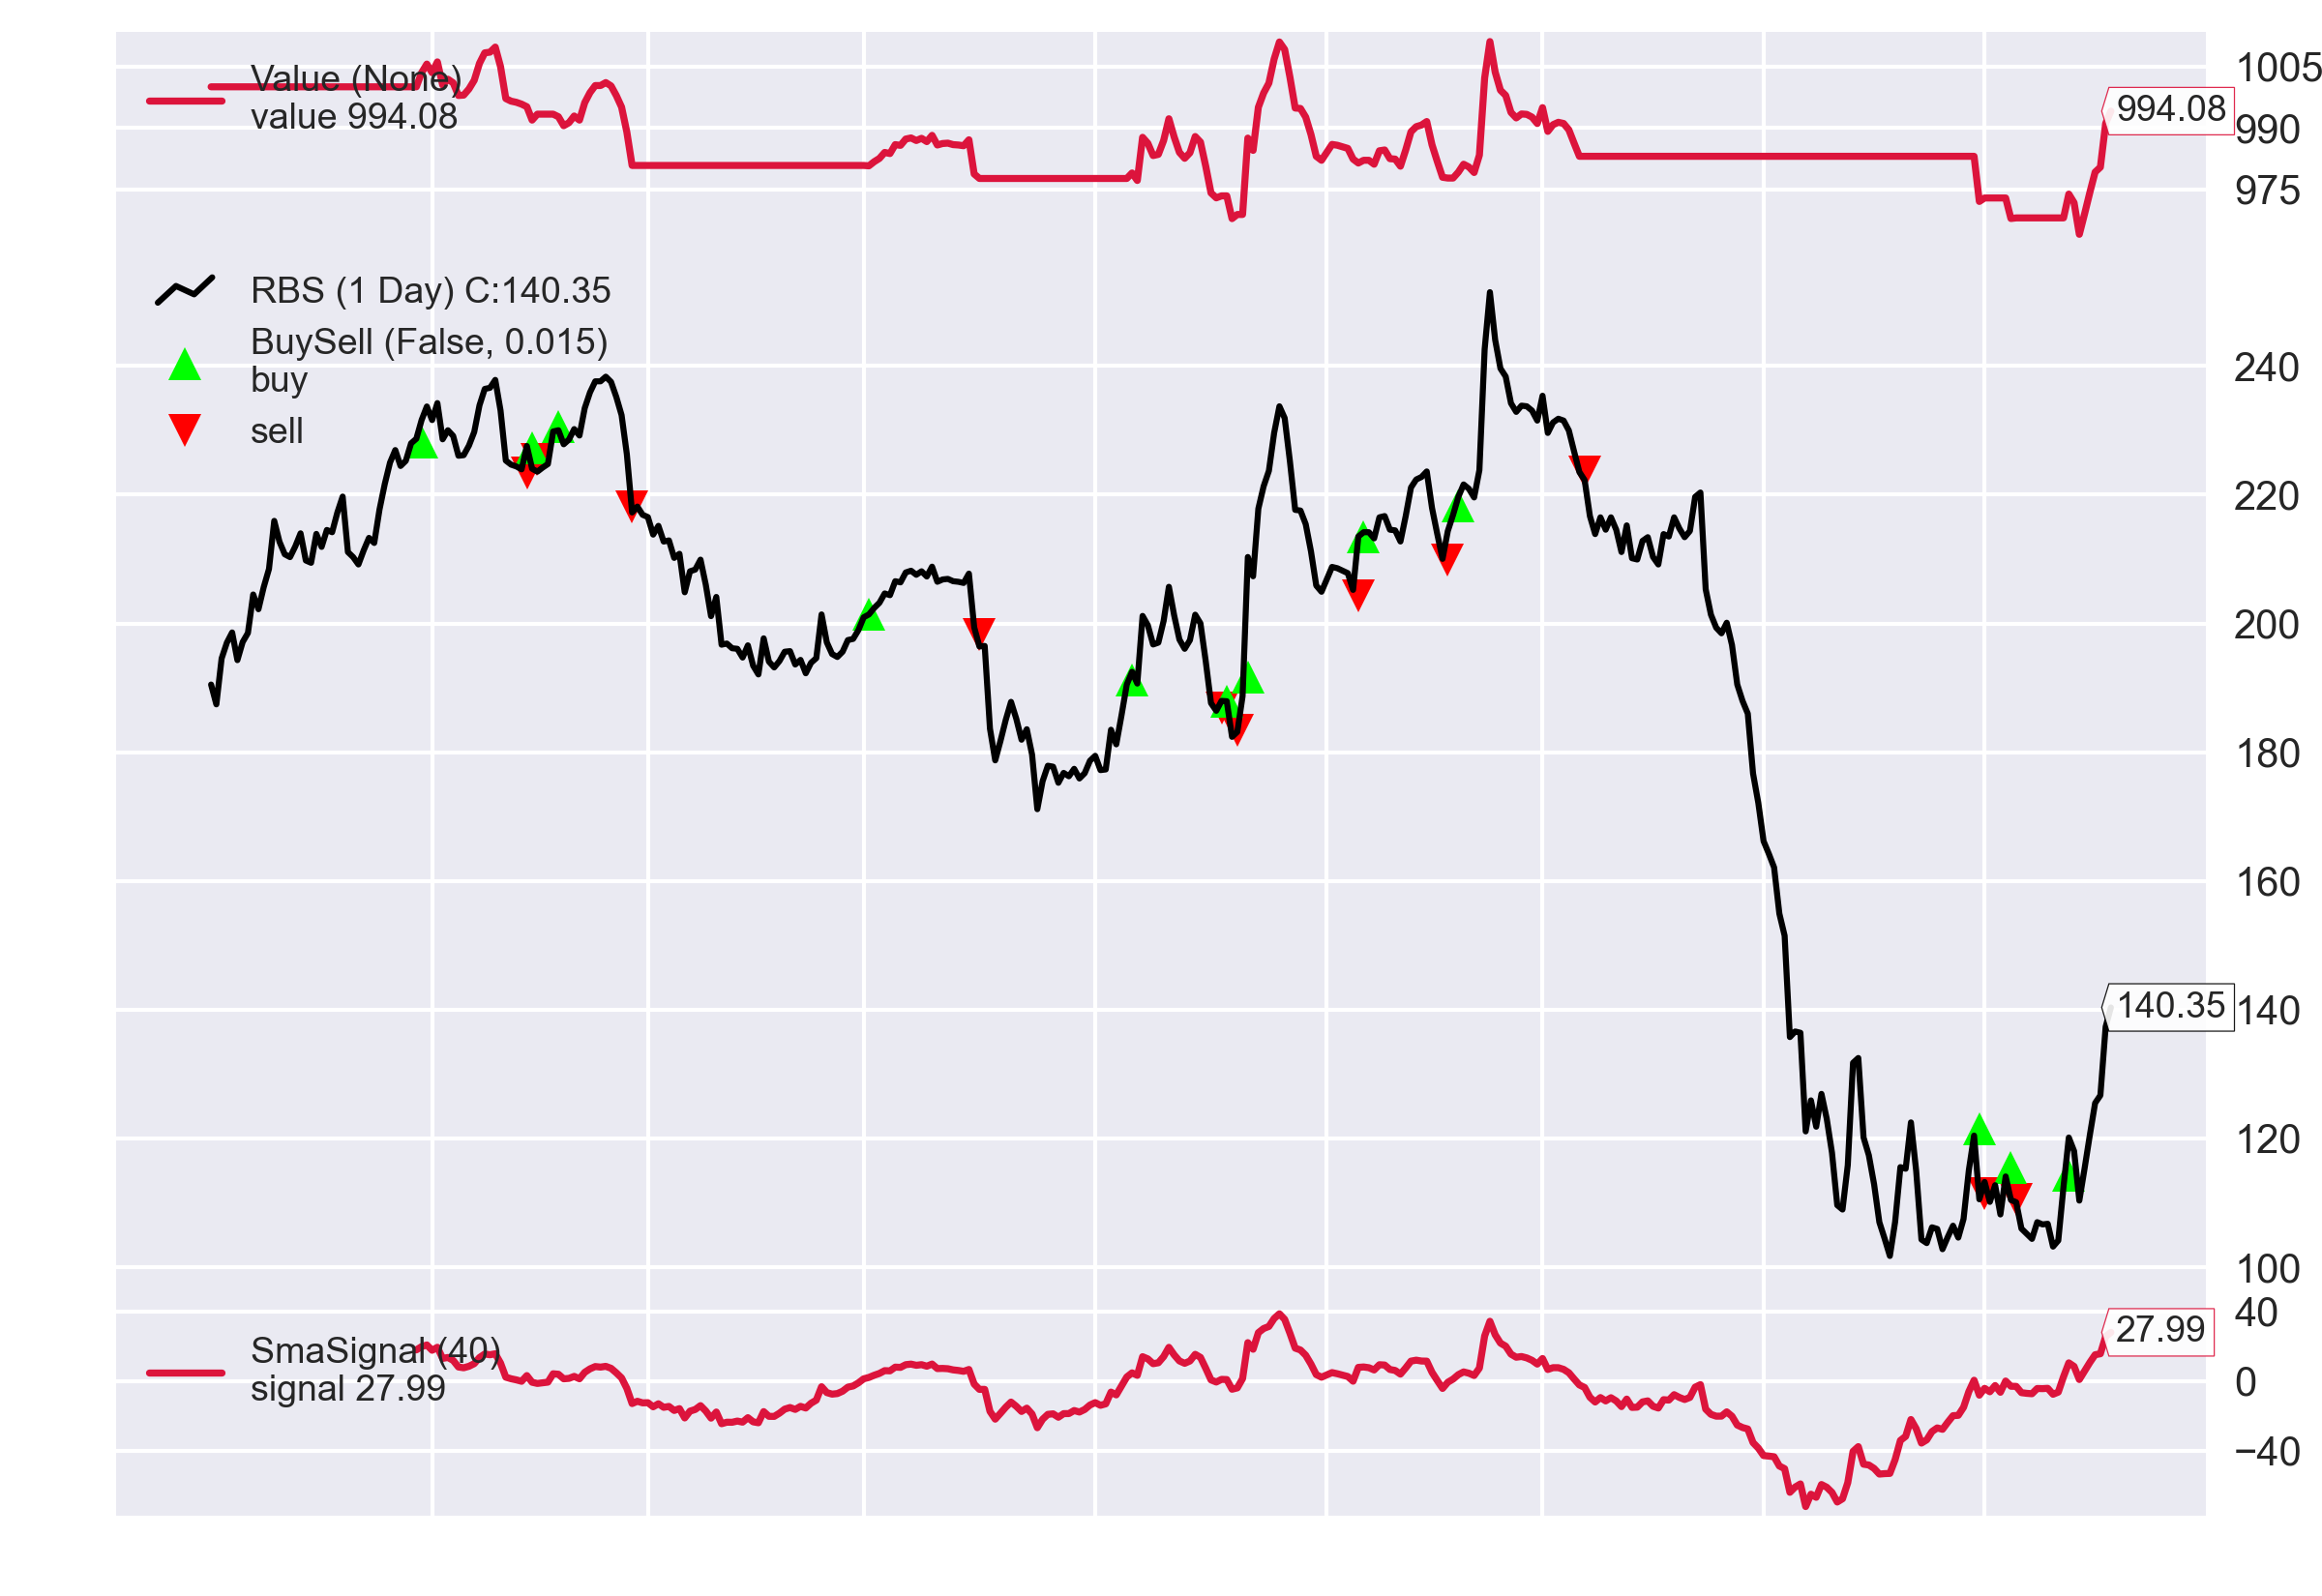

[[<Figure size 2400x1650 with 3 Axes>]]

In [14]:
cerebro.plot(iplot=True, volume = False, lw=1)

In [15]:
class SmaStrategy(bt.Strategy):
    params = (('ma_period', 20), )

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close

        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

        # add a simple moving average indicator
        self.sma = bt.ind.SMA(self.datas[0],
                              period=self.params.ma_period)
        
    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.data_close[0] > self.sma[0]:
                self.log(f'BUY CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.buy()
        else:
            # sell condition
            if self.data_close[0] < self.sma[0]:            
                self.log(f'SELL CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.sell()

In [16]:
cerebro = bt.Cerebro(stdstats = False)

cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.addstrategy(SmaStrategy)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

In [17]:
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 1000.00
2019-01-29, BUY CREATED --- Price: 209.42
2019-01-30, BUY EXECUTED --- Price: 209.60, Cost: 209.60, Commission: 0.00
2019-02-08, SELL CREATED --- Price: 210.30
2019-02-11, SELL EXECUTED --- Price: 209.95, Cost: 209.60, Commission: 0.00
2019-02-11, OPERATION RESULT --- Gross: 0.35, Net: 0.35
2019-02-13, BUY CREATED --- Price: 213.29
2019-02-14, BUY EXECUTED --- Price: 211.80, Cost: 211.80, Commission: 0.00
2019-02-14, SELL CREATED --- Price: 212.50
2019-02-15, SELL EXECUTED --- Price: 215.49, Cost: 211.80, Commission: 0.00
2019-02-15, OPERATION RESULT --- Gross: 3.69, Net: 3.69
2019-02-15, BUY CREATED --- Price: 217.69
2019-02-18, BUY EXECUTED --- Price: 219.63, Cost: 219.63, Commission: 0.00
2019-03-21, SELL CREATED --- Price: 225.30
2019-03-22, SELL EXECUTED --- Price: 226.66, Cost: 219.63, Commission: 0.00
2019-03-22, OPERATION RESULT --- Gross: 7.03, Net: 7.03
2019-04-03, BUY CREATED --- Price: 229.82
2019-04-04, BUY EXECUTED --- Price: 230.64, Cost